<img src="embed.gif">

In [1]:
import json
import math
import numpy as np
import openai
import os
import pandas as pd
import pytz
import requests
import sys

from datetime import datetime
from dotenv import load_dotenv
from IPython.display import display
from itertools import combinations
from PIL import Image
import emoji

In [21]:
from openai import AzureOpenAI
from dotenv import load_dotenv
load_dotenv()

client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version = os.getenv("AZURE_OPENAI_VERSION"),
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)

deployment_name = os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME")
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

# use an embeddingsmodel to create embeddings
def openai_text_embeddings(text, model=embedding_model):
    return client.embeddings.create(input = [text], model=model).data[0].embedding

def text_comparison(vector1, vector2):
    """
    Cosine similarity value between two embedded vectors
    """
    if len(vector1) != len(vector2):
        print("[Error] Vectors do not have the same size")
        return None

    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = round(dot_product / (magnitude1 * magnitude2), 15)

    # Or we can use directly the cosine_similarity function from Open AI

    if cosine_similarity == 1:
        decision = "identical"
        color_code = "\033[1;31;34m"
        emoticon = emoji.emojize(":red_heart:")

    elif cosine_similarity >= 0.3:
        decision = "similar semantic"
        color_code = "\033[1;31;32m"
        emoticon = emoji.emojize(":thumbs_up:")

    else:
        decision = "different"
        color_code = "\033[1;31;91m"
        emoticon = emoji.emojize(":fire:")

    print(
        f"{emoticon} {color_code}{decision.upper()} text (cosine similarity = {cosine_similarity})"
    )
    print("\033[0m")

# Text embeddings with Azure OpenAI

In [3]:
text = "Hello. Good morning!"
emb = openai_text_embeddings(text)

In [4]:
print("Text vector embedding size =", len(emb))
emb[:10]

Text vector embedding size = 1536


[0.021726541221141815,
 -0.02060708776116371,
 -0.0405287966132164,
 -0.007950406521558762,
 -0.008521555922925472,
 -0.04018610715866089,
 0.03260123357176781,
 0.0384955033659935,
 0.029631255194544792,
 -0.06712153553962708]

In [22]:
text_list = [
    "Appollo 11 mission",
    "A spaceship exploring the galaxy",
    "A muddy playground near the ocean for young ones",
    "A place in the sand where children can dig and play",
]

text_list

['Appollo 11 mission',
 'A spaceship exploring the galaxy',
 'A muddy playground near the ocean for young ones',
 'A place in the sand where children can dig and play']

In [23]:
combs = list(combinations(text_list, 2))

for idx, (text1, text2) in enumerate(combs, start=1):
    print(f"{idx} Comparing", text1, "vs", text2)
    emb1 = openai_text_embeddings(text1)
    emb2 = openai_text_embeddings(text2)
    text_comparison(emb1, emb2)

1 Comparing Appollo 11 mission vs A spaceship exploring the galaxy
👍 SIMILAR SEMANTIC text (cosine similarity = 0.318498881601384)

2 Comparing Appollo 11 mission vs A muddy playground near the ocean for young ones
🔥 DIFFERENT text (cosine similarity = 0.113060961789945)

3 Comparing Appollo 11 mission vs A place in the sand where children can dig and play
🔥 DIFFERENT text (cosine similarity = 0.123620347550122)

4 Comparing A spaceship exploring the galaxy vs A muddy playground near the ocean for young ones
🔥 DIFFERENT text (cosine similarity = 0.127223989500177)

5 Comparing A spaceship exploring the galaxy vs A place in the sand where children can dig and play
🔥 DIFFERENT text (cosine similarity = 0.148972055441996)

6 Comparing A muddy playground near the ocean for young ones vs A place in the sand where children can dig and play
👍 SIMILAR SEMANTIC text (cosine similarity = 0.656156975156631)



# Image embeddings with Azure Computer vision

In [7]:
import os
import emoji
import json
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import requests
from PIL import Image
import math

# Get Azure Computer Vision credentials
azure_cv_endpoint = os.getenv("azure_cv_endpoint")
azure_cv_key = os.getenv("azure_cv_key")

version = "?api-version=2023-02-01-preview&modelVersion=latest"

vec_img_url = (
    azure_cv_endpoint + "/computervision/retrieval:vectorizeImage" + version
)  # For doing the image vectorization

vec_txt_url = (
    azure_cv_endpoint + "/computervision/retrieval:vectorizeText" + version
)  # For the prompt vectorization

headers = {
    "Content-type": "application/json",
    "Ocp-Apim-Subscription-Key": azure_cv_key,
}

In [8]:
def image_embedding(imageurl):
    """
    Embedding image using Azure Computer Vision 4
    """
    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    image_emb = r.json()["vector"]

    return image_emb

In [9]:
def images_comparison(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cos_similarity = round(dot_product / (magnitude1 * magnitude2), 10)

    if cos_similarity == 1:
        decision = "identical"
        color_code = "\033[1;31;34m"
        emoticon = emoji.emojize(":red_heart:")
    elif cos_similarity >= 0.8:
        decision = "similar"
        color_code = "\033[1;31;32m"
        emoticon = emoji.emojize(":thumbs_up:")
    else:
        decision = "different"
        color_code = "\033[1;31;91m"
        emoticon = emoji.emojize(":fire:")

    print(
        f"{emoticon} {color_code}{decision.upper()} images (cosine similarity = {cos_similarity})"
    )

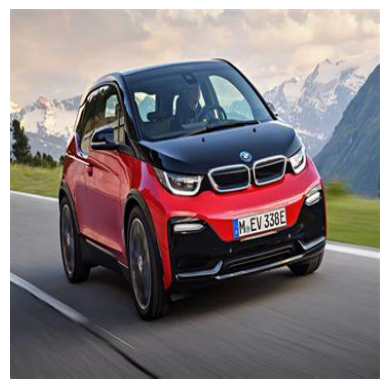

In [10]:
url1 = os.getenv("IMAGE_PATH")+ "car1.png"
redi3 = image_embedding(url1)

plt.imshow(Image.open(requests.get(url1, stream=True).raw))
plt.axis("off")
plt.show()

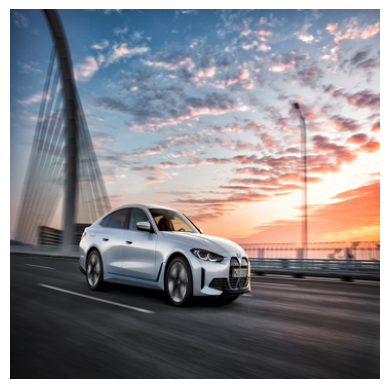

In [11]:
url2 = os.getenv("IMAGE_PATH")+ "car2.png?raw=true"
car2_emb = image_embedding(url2)

plt.imshow(Image.open(requests.get(url2, stream=True).raw))
plt.axis("off")
plt.show()

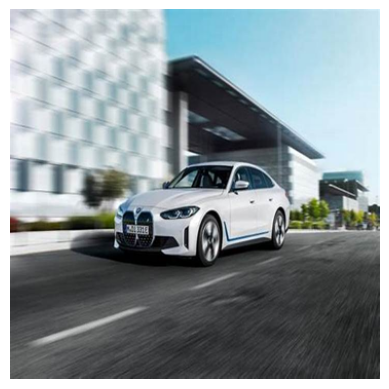

In [12]:
url3 = os.getenv("IMAGE_PATH")+ "car3.png?raw=true"
car3_emb = image_embedding(url3)

plt.imshow(Image.open(requests.get(url3, stream=True).raw))
plt.axis("off")
plt.show()

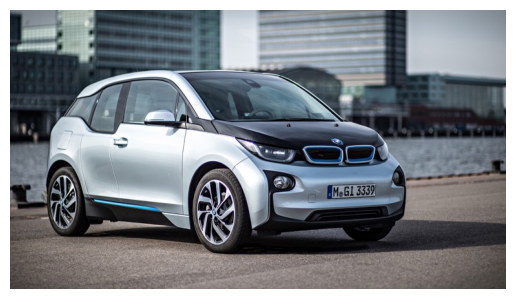

In [13]:
url4 = os.getenv("IMAGE_PATH")+ "car4.jpg?raw=true"
whitei3 = image_embedding(url4)

plt.imshow(Image.open(requests.get(url4, stream=True).raw))
plt.axis("off")
plt.show()

In [14]:
images_comparison(whitei3, whitei3)

❤️ IDENTICAL images (cosine similarity = 1.0)


In [15]:
images_comparison(whitei3, car2_emb)

🔥 DIFFERENT images (cosine similarity = 0.5707733094)


In [16]:
images_comparison(whitei3, car3_emb)

🔥 DIFFERENT images (cosine similarity = 0.6603665652)


In [17]:
images_comparison(whitei3, car3_emb)
images_comparison(whitei3, car2_emb)
images_comparison(whitei3, redi3)
images_comparison(car2_emb, car3_emb)

🔥 DIFFERENT images (cosine similarity = 0.6751229148)
🔥 DIFFERENT images (cosine similarity = 0.5887884697)
👍 SIMILAR images (cosine similarity = 0.8498804124)
👍 SIMILAR images (cosine similarity = 0.8385041364)


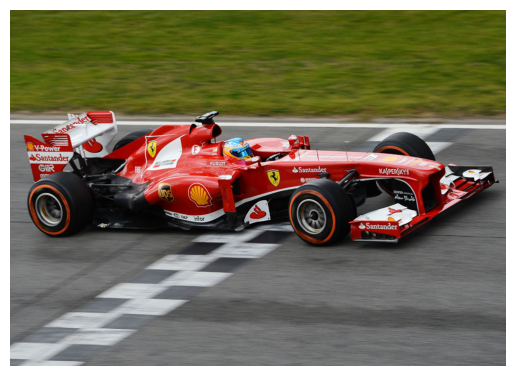

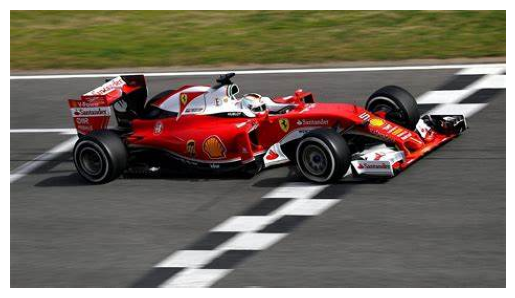

👍 SIMILAR images (cosine similarity = 0.8121530946)


In [18]:
url5 = "https://f1.imgci.com/PICTURES/CMS/17700/17793.jpg"
something2 = image_embedding(url5)

plt.imshow(Image.open(requests.get(url5, stream=True).raw))
plt.axis("off")
plt.show()

url6 = "https://th.bing.com/th/id/OIP.wxU79HM3DqR4f_fw2nEuEwHaEK?rs=1&pid=ImgDetMain"
something3 = image_embedding(url6)

plt.imshow(Image.open(requests.get(url6, stream=True).raw))
plt.axis("off")
plt.show()

images_comparison(something2, something3)